# Sentimental Analysis on US elections Tweets 
------------------

### Importing the Modules

In [167]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
#pip install plotly

sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loicb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\loicb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [168]:
import plotly.express as px

### Importing the Dataset

In [169]:
df = pd.read_excel  ('data/US2020.xlsx')
df.head()

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1327225962661023755,RT @linfolibre : Puisque les trolls ne veulent...,Annick,Annickxena,2020-11-13T12:25:02.000Z,Fri Nov 13 12:25:02 +0000 2020,0,0,fr,"<a href=""http://twitter.com/download/android"" ...",Retweet,https://www.newsmax.com/newsmax-tv/trey-traino...,4,0,NaN,NaN,NaN,NaN,NaN
1,1327223379615772673,Joseph R. #Biden Jr. is the president-elect of...,Gender & Policy Insights,GenderPolicyIns,2020-11-13T12:14:46.000Z,Fri Nov 13 12:14:46 +0000 2020,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,NaN,7,0,NaN,NaN,NaN,NaN,NaN
2,1327219804290347010,"@TTuberville, who is about the be sworn in as ...",Sarah,SarahMya2000,2020-11-13T12:00:34.000Z,Fri Nov 13 12:00:34 +0000 2020,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Tweet,https://www.aldailynews.com/in-the-weeds-w-tom...,10,1,photo,https://pbs.twimg.com/media/Ems7YGOXIAcQ4UH.jpg,NaN,NaN,NaN
3,1327211784101629952,Maptastic: How map makers will win the 2020 #U...,Mike. Try out a bit of cognitive estrangement,RocketGoal,2020-11-13T11:28:42.000Z,Fri Nov 13 11:28:42 +0000 2020,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://youtu.be/Kb3YZs0F468,5,1,NaN,NaN,NaN,NaN,NaN
4,1327209698655940608,"#Biden cements victory by winning #Arizona, bu...",LBCI Lebanon News EN,LBCI_News_EN,2020-11-13T11:20:25.000Z,Fri Nov 13 11:20:25 +0000 2020,6,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://www.lbcgroup.tv/news/regional/559237/b...,5,0,NaN,NaN,NaN,NaN,NaN


let's check the shape of the dataframe

In [170]:
df.shape

(2023, 19)

let's select the needed columns for our project

In [171]:
needed_columns = ['Name','Text','UTC']
df = df [needed_columns]
df.head()

,Name,Text,UTC
0,Annick,RT @linfolibre : Puisque les trolls ne veulent...,2020-11-13T12:25:02.000Z
1,Gender & Policy Insights,Joseph R. #Biden Jr. is the president-elect of...,2020-11-13T12:14:46.000Z
2,Sarah,"@TTuberville, who is about the be sworn in as ...",2020-11-13T12:00:34.000Z
3,Mike. Try out a bit of cognitive estrangement,Maptastic: How map makers will win the 2020 #U...,2020-11-13T11:28:42.000Z
4,LBCI Lebanon News EN,"#Biden cements victory by winning #Arizona, bu...",2020-11-13T11:20:25.000Z


change the type of some columns

In [172]:
df.Name = df.Name.astype('category')
df.Name = df.Name.cat.codes

df.UTC = pd.to_datetime(df.UTC).dt.date
df.head()

,Name,Text,UTC
0,111,RT @linfolibre : Puisque les trolls ne veulent...,2020-11-13
1,477,Joseph R. #Biden Jr. is the president-elect of...,2020-11-13
2,1129,"@TTuberville, who is about the be sworn in as ...",2020-11-13
3,876,Maptastic: How map makers will win the 2020 #U...,2020-11-13
4,721,"#Biden cements victory by winning #Arizona, bu...",2020-11-13


### Picking out the tweet texts

In [173]:
texts = df['Text']
texts

0       RT @linfolibre : Puisque les trolls ne veulent...
1       Joseph R. #Biden Jr. is the president-elect of...
2       @TTuberville, who is about the be sworn in as ...
3       Maptastic: How map makers will win the 2020 #U...
4       #Biden cements victory by winning #Arizona, bu...
                              ...                        
2018    CNA: ‘We're going to win this race': Biden pre...
2019    RT @AlArabiya_Eng : ICYMI: Two men armed with ...
2020    RT @SrezahJ : As an Iranian student, It's not ...
2021    RT @prclondon : Palestinian-American women Ras...
2022    Elections are heating up but Gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing URLs from tweets

In [174]:
remove_url = lambda x: re.sub(r'https\S+' , '', str(x))
texts_lr = texts.apply(remove_url)
texts_lr

0       RT @linfolibre : Puisque les trolls ne veulent...
1       Joseph R. #Biden Jr. is the president-elect of...
2       @TTuberville, who is about the be sworn in as ...
3       Maptastic: How map makers will win the 2020 #U...
4       #Biden cements victory by winning #Arizona, bu...
                              ...                        
2018    CNA: ‘We're going to win this race': Biden pre...
2019    RT @AlArabiya_Eng : ICYMI: Two men armed with ...
2020    RT @SrezahJ : As an Iranian student, It's not ...
2021    RT @prclondon : Palestinian-American women Ras...
2022    Elections are heating up but Gold got no chill...
Name: Text, Length: 2023, dtype: object

### Converting all tweets to lowercase

In [175]:
to_lower = lambda x : x.lower()
texts_lr_lc = texts_lr.apply(to_lower)
texts_lr_lc

0       rt @linfolibre : puisque les trolls ne veulent...
1       joseph r. #biden jr. is the president-elect of...
2       @ttuberville, who is about the be sworn in as ...
3       maptastic: how map makers will win the 2020 #u...
4       #biden cements victory by winning #arizona, bu...
                              ...                        
2018    cna: ‘we're going to win this race': biden pre...
2019    rt @alarabiya_eng : icymi: two men armed with ...
2020    rt @srezahj : as an iranian student, it's not ...
2021    rt @prclondon : palestinian-american women ras...
2022    elections are heating up but gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing punctuations

In [176]:
remove_puncs = lambda x : x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np

0       rt linfolibre  puisque les trolls ne veulent p...
1       joseph r biden jr is the presidentelect of the...
2       ttuberville who is about the be sworn in as a ...
3       maptastic how map makers will win the 2020 us ...
4       biden cements victory by winning arizona but t...
                              ...                        
2018    cna ‘were going to win this race biden predict...
2019    rt alarabiyaeng  icymi two men armed with hand...
2020    rt srezahj  as an iranian student its not impo...
2021    rt prclondon  palestinianamerican women rashid...
2022    elections are heating up but gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing stopwords

In [177]:
more_words = ['even','election2020','rt','elections','election', 'us', 'après', 'going','ccp','news','chinas']
stop_words = set(stopwords.words())
stop_words.update(more_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0       linfolibre puisque trolls veulent entendre par...
1       joseph r biden jr presidentelect united states...
2       ttuberville sworn senator thinks three branche...
3       maptastic map makers win 2020 help explain imp...
4       biden cements victory winning arizona trump st...
                              ...                        
2018    cna ‘were win race biden predicts victory lead...
2019    alarabiyaeng icymi two armed handguns arrested...
2020    srezahj iranian student important win election...
2021    prclondon palestinianamerican women rashida tl...
2022    heating gold got chill uselectionresults2020 c...
Name: Text, Length: 2023, dtype: object

### let's create a big list of words out of all the tweets 

In [178]:
words_list = [word for line in texts_lr_lc_np_ns for word in line.split()]

In [179]:
word_counts = Counter(words_list).most_common(30)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word','frq']
words_df.head()

,word,frq
0,joebiden,656
1,ccpchina,366
2,gordongchang,364
3,trump,352
4,presidential,341


In [180]:
#conda install -c plotly plotly-orca

In [181]:
fig = px.bar(words_df, x='word',y='frq',title='Most common words', color='frq')
fig.write_image("img/Mostcommonwords.png", width=1960, height=1080)
fig.show()

In [182]:
#pip install wordcloud

In [183]:
all_words = ' ' .join([text for text in words_df['word']])

In [184]:
from wordcloud import WordCloud

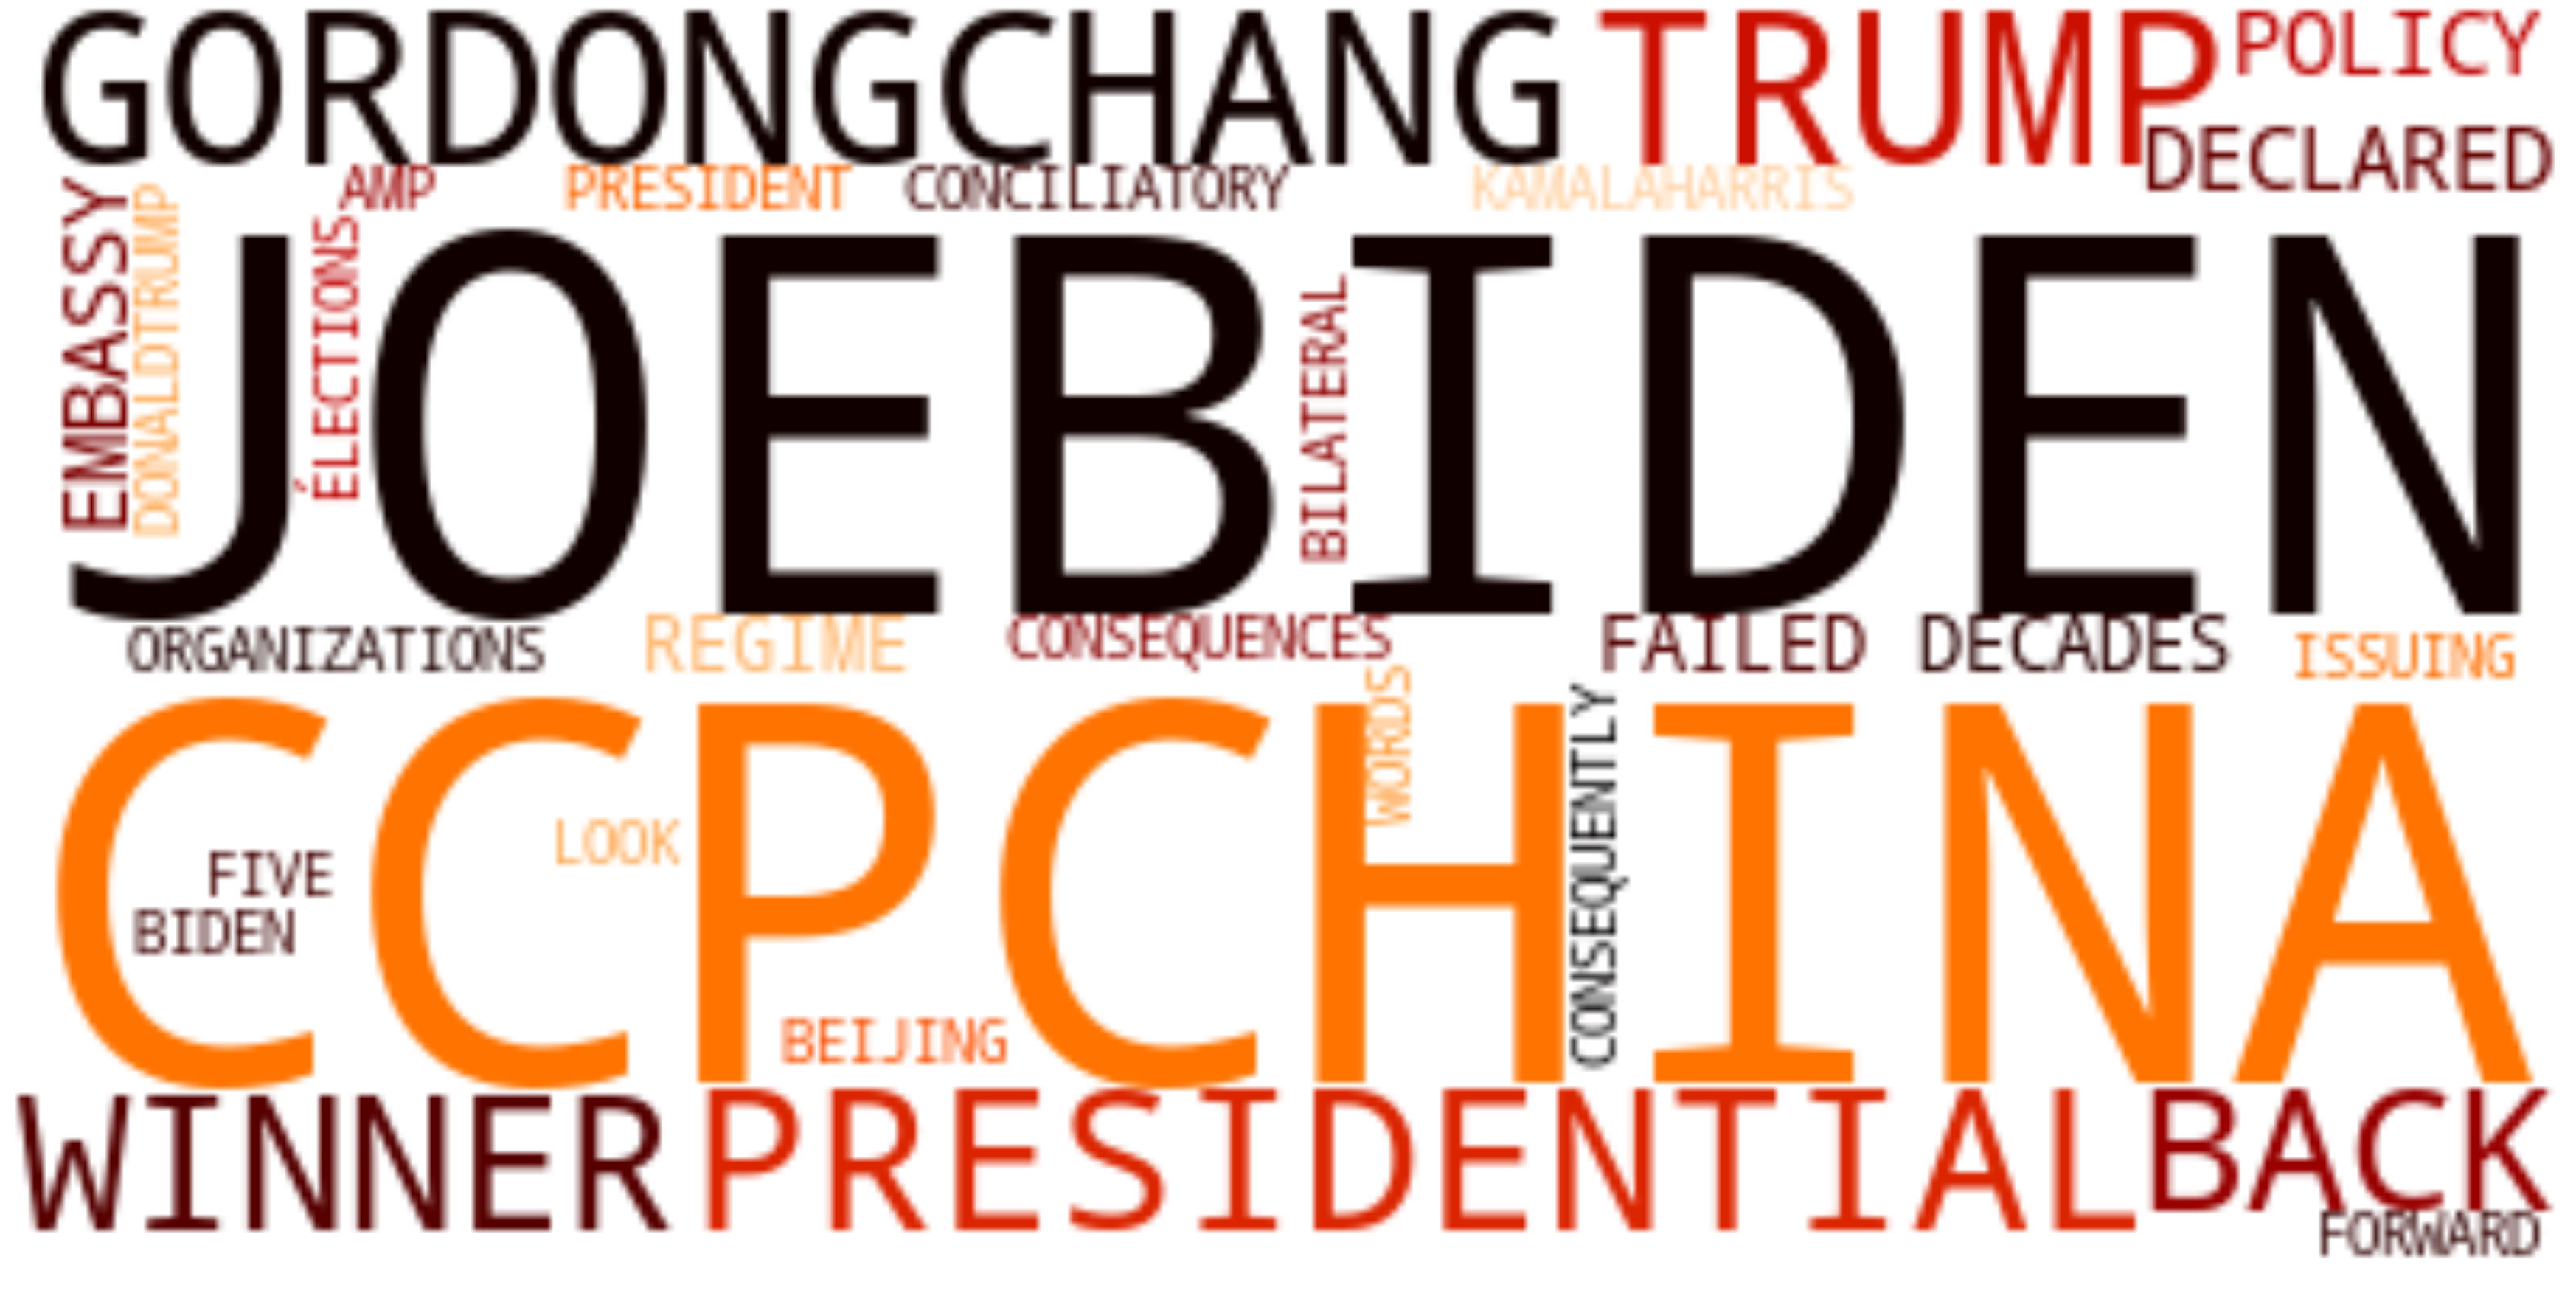

In [185]:
word_cloud = WordCloud(background_color='white', max_font_size=300,
                      max_words=50000, colormap='gist_heat')
word_cloud.generate(all_words.upper())
fig = plt.figure(figsize=[64, 32])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()
fig.savefig('img/wordcloud.png')

### put the Cleaned text in main dataframe

In [186]:
dftext = texts_lr_lc_np_ns
df.head()

,Name,Text,UTC
0,111,RT @linfolibre : Puisque les trolls ne veulent...,2020-11-13
1,477,Joseph R. #Biden Jr. is the president-elect of...,2020-11-13
2,1129,"@TTuberville, who is about the be sworn in as ...",2020-11-13
3,876,Maptastic: How map makers will win the 2020 #U...,2020-11-13
4,721,"#Biden cements victory by winning #Arizona, bu...",2020-11-13


# Sentiment Analysis 

Getting the polarity scores for each tweet

In [187]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.Text.apply(ps)
sentiment_scores

0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...
2       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3       {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...
4       {'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...
                              ...                        
2018    {'neg': 0.117, 'neu': 0.834, 'pos': 0.049, 'co...
2019    {'neg': 0.1, 'neu': 0.9, 'pos': 0.0, 'compound...
2020    {'neg': 0.03, 'neu': 0.774, 'pos': 0.196, 'com...
2021    {'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...
2022    {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...
Name: Text, Length: 2023, dtype: object

In [188]:
sentiment_df = pd.DataFrame (data = list(sentiment_scores))
sentiment_df.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.086,0.914,0.000,-0.4767
2,0.000,1.000,0.000,0.0000
3,0.000,0.727,0.273,0.8402
4,0.000,0.864,0.136,0.2960


### Labeling the scores based on the compound polarity value

In [189]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

,neg,neu,pos,compound,label
0,0.000,1.000,0.000,0.0000,neutral
1,0.086,0.914,0.000,-0.4767,negative
2,0.000,1.000,0.000,0.0000,neutral
3,0.000,0.727,0.273,0.8402,positive
4,0.000,0.864,0.136,0.2960,positive


### let's join two dataframes

In [190]:
data = df.join (sentiment_df.label)
data.head()

,Name,Text,UTC,label
0,111,RT @linfolibre : Puisque les trolls ne veulent...,2020-11-13,neutral
1,477,Joseph R. #Biden Jr. is the president-elect of...,2020-11-13,negative
2,1129,"@TTuberville, who is about the be sworn in as ...",2020-11-13,neutral
3,876,Maptastic: How map makers will win the 2020 #U...,2020-11-13,positive
4,721,"#Biden cements victory by winning #Arizona, bu...",2020-11-13,positive


### Plotting the sentiment score counts

In [191]:
count_df = data.label.value_counts().reset_index()
count_df

,index,label
0,positive,1076
1,neutral,643
2,negative,304


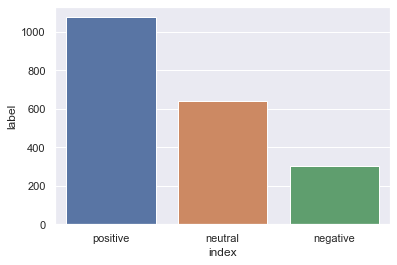

In [192]:
fig = sns.barplot(x='index', y='label', data= count_df)
# Saving the Seaborn Figure:
plt.savefig('img/count.png')

In [193]:
data.head()

,Name,Text,UTC,label
0,111,RT @linfolibre : Puisque les trolls ne veulent...,2020-11-13,neutral
1,477,Joseph R. #Biden Jr. is the president-elect of...,2020-11-13,negative
2,1129,"@TTuberville, who is about the be sworn in as ...",2020-11-13,neutral
3,876,Maptastic: How map makers will win the 2020 #U...,2020-11-13,positive
4,721,"#Biden cements victory by winning #Arizona, bu...",2020-11-13,positive


In [194]:
data_agg = data [['Name','UTC','label']].groupby (['UTC','label']).count().reset_index()
data_agg.columns = ['UTC','label','counts']
data_agg.head()

,UTC,label,counts
0,2020-11-07,negative,63
1,2020-11-07,neutral,121
2,2020-11-07,positive,448
3,2020-11-08,negative,34
4,2020-11-08,neutral,235


In [195]:
fig = px.line(data_agg, x='UTC', y='counts', color='label', title = 'daily tweets sentimental analysis')
fig.write_image("img/daily tweets sentimental analysis.png",width=1000, height=500)
fig.show()